# TP 2

#### ▪ Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier

In [1]:
%matplotlib inline  
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('dark_background')


# Definimos la función del enunciado:
def create_gauss_filter(h, w, k_size=5, sigma=5):
    # Primero, creamos el filtro gaussiano en dominio espacial con los parámetros obtenidos
    # como vimos en clase:
    kernel = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    kernel = np.dot(kernel,kernel.T)
    
    # Ahora, debemos añadir padding al kernel hasta cumplir con las dimensiones argumento.
    # Para esto, primero calculamos cuanto debemos añadir a cada lado:
    kh, kw = kernel.shape
    padding_height = (h - kh) // 2
    padding_width = (w - kw) // 2

    # Calcula el padding para las dimensiones impares
    padding_height_extra = (h - kh) % 2
    padding_width_extra = (w - kw) % 2

    # Ahora simplemente añadimos el padding con np.pad
    filter = np.pad(kernel, ((padding_height, padding_height + padding_height_extra),
                                    (padding_width, padding_width + padding_width_extra)),
                           mode='constant', constant_values=0)
    
    # Ya tenemos el filtro en dominio espacial. Ahora calculamos su transformada de Fourier
    # para devolver ambos:
    filter_fft = np.fft.fft2(filter)

    return filter, filter_fft

#### 1) Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral. 


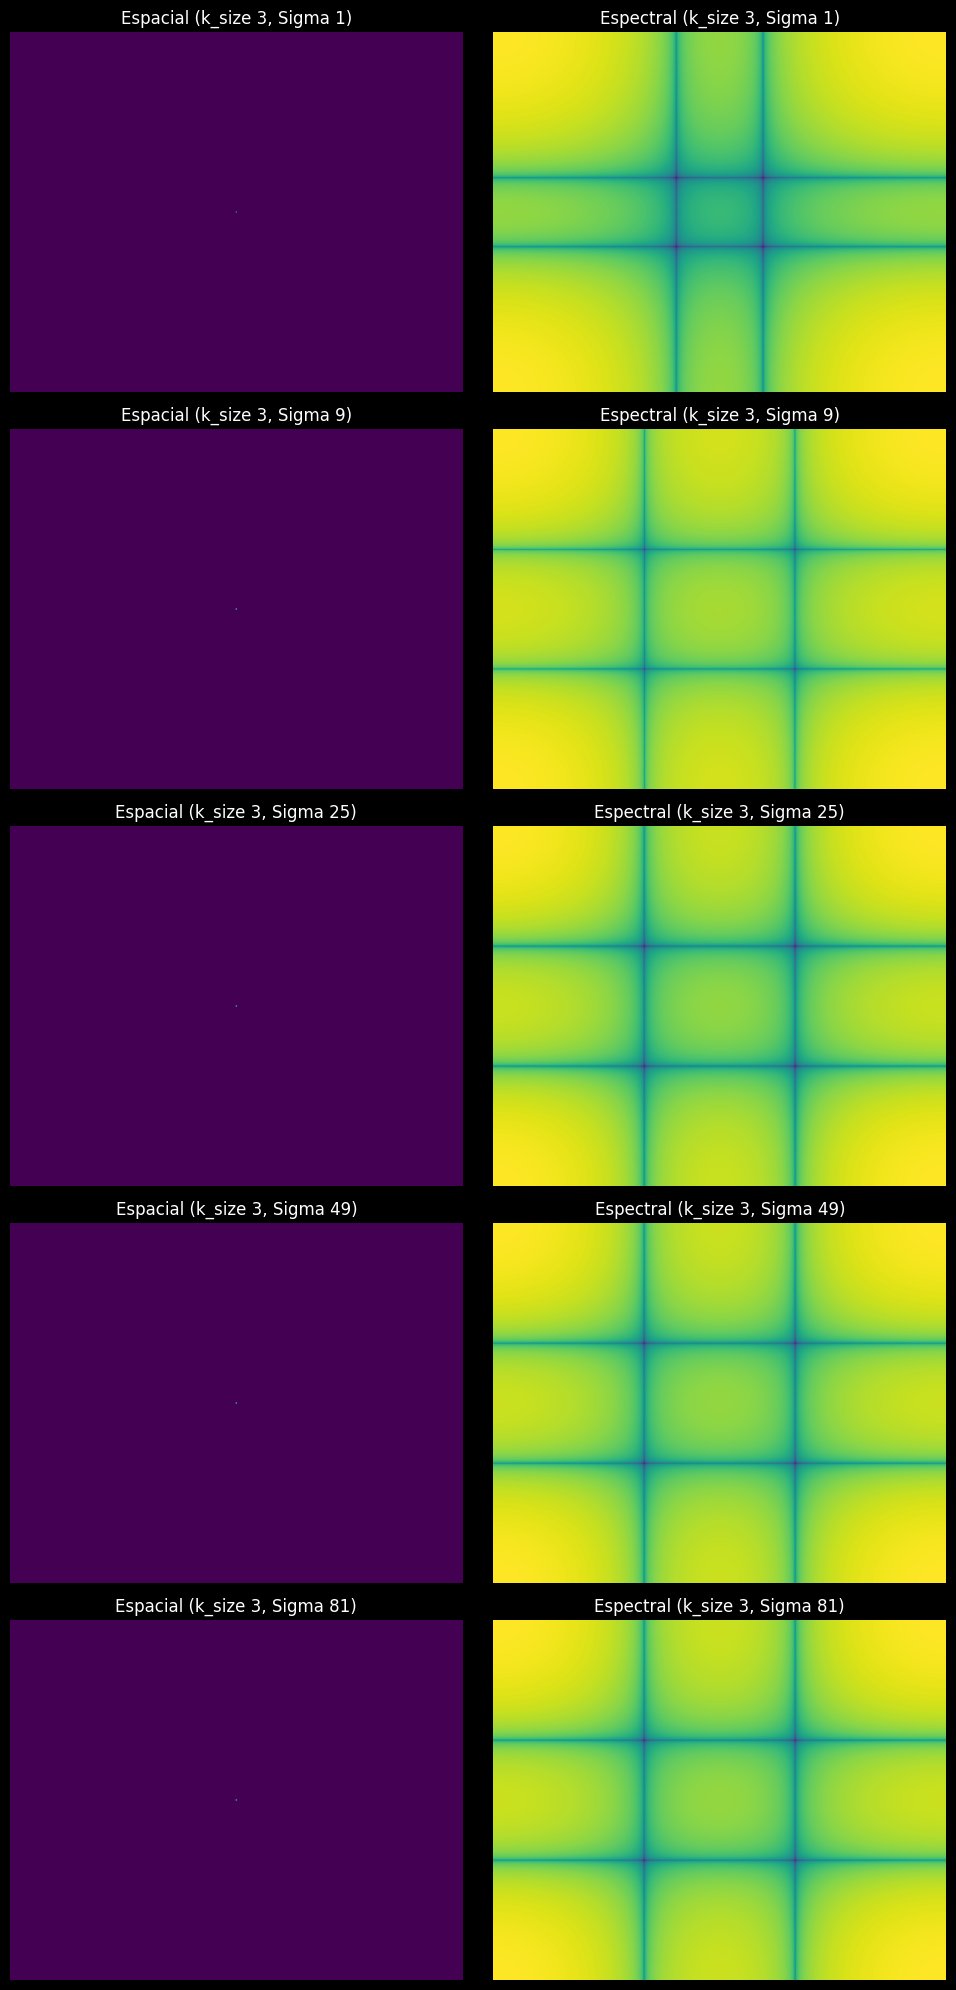

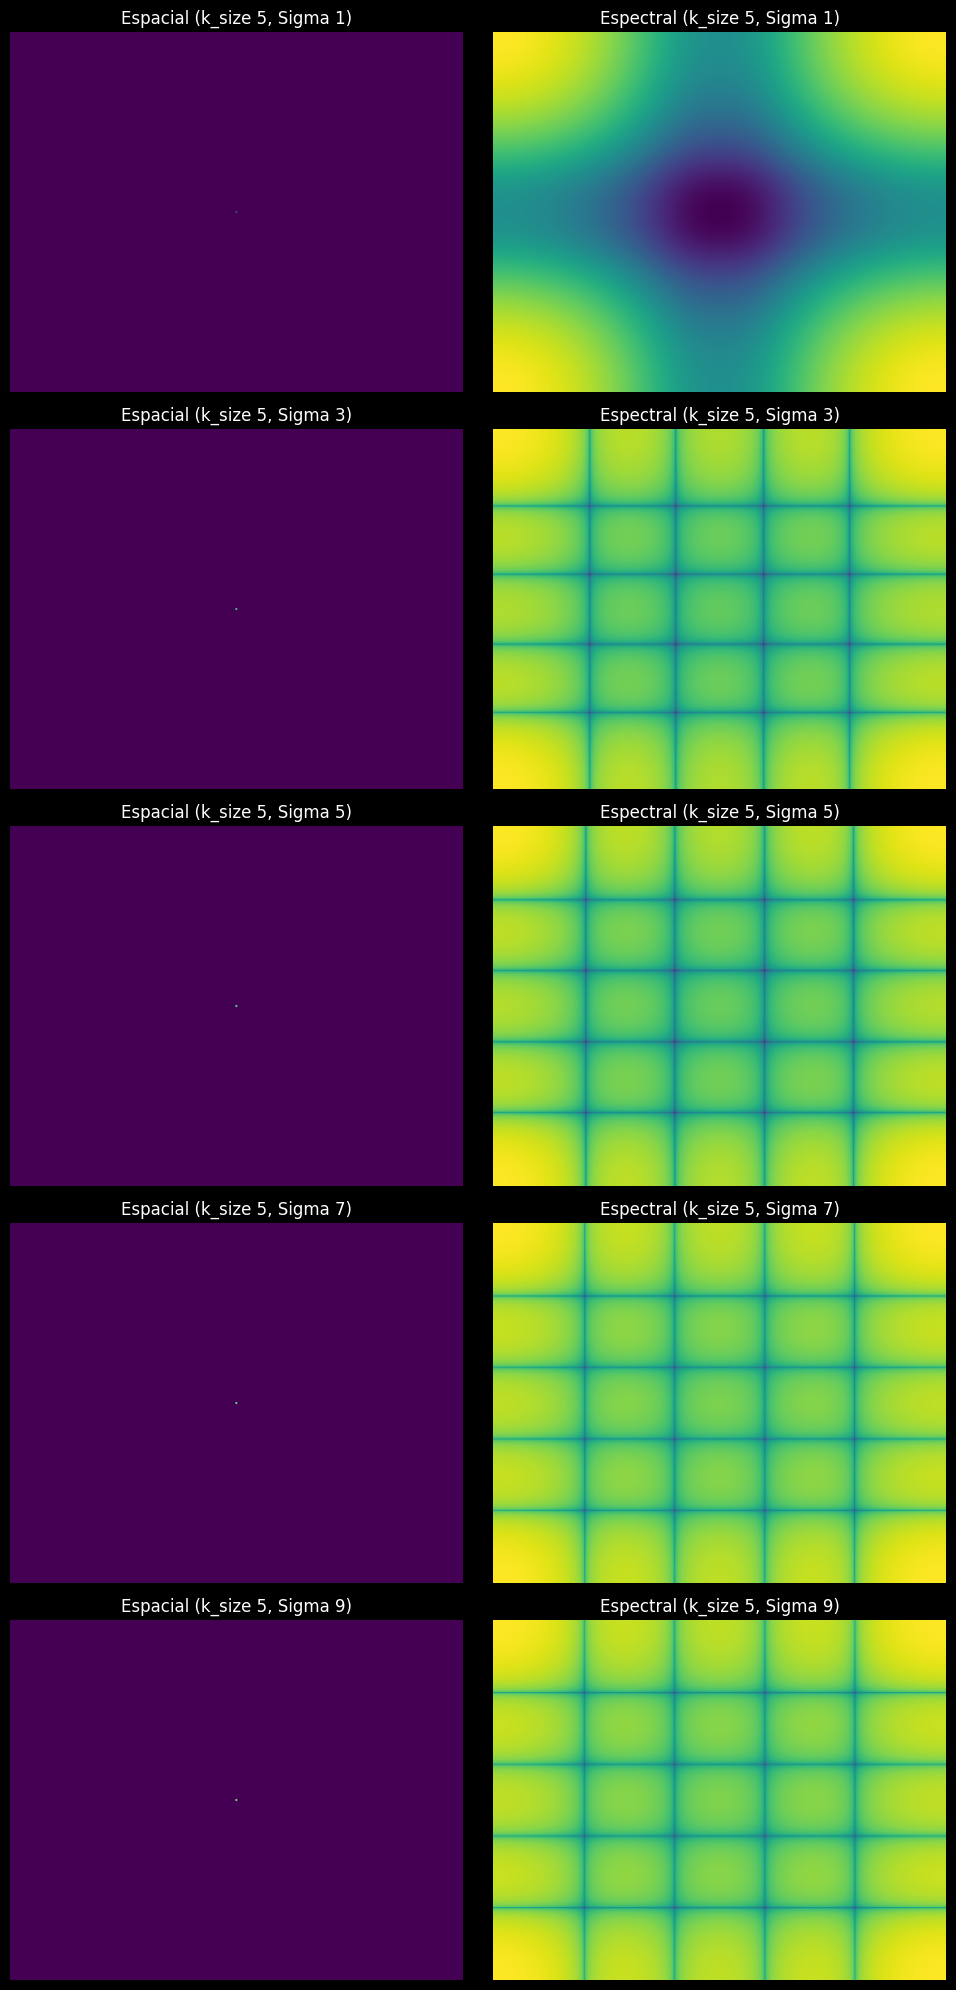

In [2]:
# Visualicemos los filtros en dominio espacial y espectral
# para distintos valores de sigma y k_size (usaremos h y w
# iguales a las de la imagen de ejemplo para los siguientes puntos)
img = cv.imread('Imgs\original.jpg',cv.IMREAD_GRAYSCALE)
h, w = img.shape

plt.subplots(5,2,figsize=(10,20))

for i in range(1,11,2):
    filter, filter_fft = create_gauss_filter(h, w, 3, i*i)
    # Tomamos el módulo en el caso espectral para poder graficarlo
    filter_fft_mod = 20*np.log(np.abs(filter_fft))
    plt.subplot(5, 2, i)
    plt.title(f'Espacial (k_size 3, Sigma {i*i})')
    plt.imshow(filter)
    plt.axis('off')
    plt.subplot(5, 2, i+1)
    plt.title(f'Espectral (k_size 3, Sigma {i*i})')
    plt.imshow(filter_fft_mod)
    plt.axis('off')
    
plt.tight_layout()
plt.show()

plt.subplots(5,2,figsize=(10,20))
for i in range(1,11,2):
    filter, filter_fft = create_gauss_filter(h, w, 5, i)
    # Tomamos el módulo en el caso espectral para poder graficarlo
    filter_fft_mod = 20*np.log(np.abs(filter_fft))
    plt.subplot(5, 2, i)
    plt.title(f'Espacial (k_size 5, Sigma {i})')
    plt.imshow(filter)
    plt.axis('off')
    plt.subplot(5, 2, i+1)
    plt.title(f'Espectral (k_size 5, Sigma {i})')
    plt.imshow(filter_fft_mod)
    plt.axis('off')

plt.tight_layout()
plt.show()

Ahora aplicaremos el filtro a una imagen de ejemplo para ver que tal funciona, y lo compararemos al filtro de OpenCV

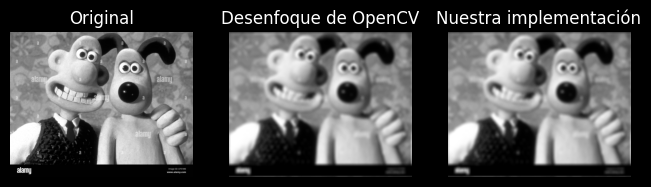

In [3]:
# Filtro aplicado en el dominio espacial:
img_normal_blur = cv.GaussianBlur(img, ksize=(31, 31), sigmaX=10,  sigmaY=10)

# Filtro aplicado en el dominio espectral:
img_fft = np.fft.fft2(img)
filter, filter_fft = create_gauss_filter(h, w, 31, 10)
img_fft_filtered = img_fft * filter_fft

# Antitransformamos, hacemos un shif para que la disposición sea la correcta
# y eliminamos los residuos no reales para obtener la imagen filtrada:
img_spectral_blur = np.real(np.fft.ifftshift(np.fft.ifft2(img_fft_filtered)))


plt.figure(figsize=(8,8))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_spectral_blur, cmap='gray')
plt.title('Desenfoque de OpenCV')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img_spectral_blur, cmap='gray')
plt.title('Nuestra implementación')
plt.axis('off')

plt.show()


#### 2) Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

Basándonos en el algoritmo propuesto en el paper, definiremos una función que tiene como input una imagen, y como output la _FM_ (según el autor, "Frequency Domain Image Blur Measure") de la imagen

In [4]:
def calculate_image_FM(img):
    m = img.shape[0]
    n = img.shape[1]
    
    # Siguiendo los pasos propuestos:
    # 1- Computamos F, la transformada de Fourier de la imagen (en este caso con fft)
    F = np.fft.fft2(img)

    # 2- Hallamos Fc, que es simplemente F con el origen transladado al centro (shift)
    Fc = np.fft.fftshift(F)

    # 3- Calculamos AF, una matriz con los valores absolutos de Fc
    AF = np.abs(Fc)

    # 4- Calculamos M, el valor máximo de la matriz AF
    M = np.max(AF)

    # 5- Calculamos T, que es el número de píxeles de F cuyo valor supera la 
    # milésima parte de M
    T = np.sum(AF > M/1000)

    # 6- Calculamos FM con la siguiente fórmula:
    FM = T/(m * n)

    # Devolvemos FM
    return FM


Ahora comprobaremos que tan similar es el resultado de FM para nuestra implementaci´n y la de OpenCV. También veremos el resultado que arroja en la iamgen original

In [5]:
print(f'FM original: {calculate_image_FM(img)}')
print(f'FM blur OpenCV: {calculate_image_FM(img_normal_blur)}')
print(f'FM blur implementado: {calculate_image_FM(img_spectral_blur)}')


FM original: 0.004696552237694542
FM blur OpenCV: 0.0018862163973490207
FM blur implementado: 0.001616650532429816


#### 3) Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

Revisando el paper proporcionado, he deicdido elegir el método STA3 de varianza de niveles de grises, aparentemente uno de los más populares para cálculo de media de foco

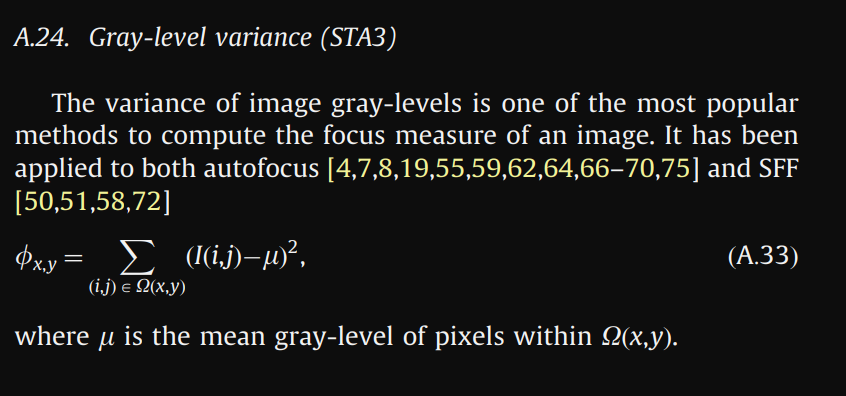

In [6]:
def calculate_focus_measure(img):
    mu = np.mean(img)
    variance = np.sum((img - mu) ** 2)
    
    return variance


print(f'FM original: {calculate_focus_measure(img)}')
print(f'FM blur OpenCV: {calculate_focus_measure(img_normal_blur)}')
print(f'FM blur implementado: {calculate_focus_measure(img_spectral_blur)}')


FM original: 7366192776.722934
FM blur OpenCV: 6525165819.272526
FM blur implementado: 6412592398.268358


Como podemos observar, esta métrica de enfoque parece funcionar ya que mantiene relaciones parecidas a las que arrojaba el método del segundo punto en cuanto a nuestras tres imágenes propuestas.

#### _Corrección_:

En este apartado crearemos un gráfico donde compararemos la métrica de calidad para valores cada vez más grandes de sigmaa en filtrado gaussiano de la imagen de ejemplo, cada kernel de tamaño k=3, 9 y 27

In [18]:
# Funciones auxiliares:
def spectral_filter(img,spectral_filter):
    img_fft = np.fft.fft2(img)
    img_fft_filtered = img_fft * spectral_filter
    return np.real(np.fft.ifftshift(np.fft.ifft2(img_fft_filtered)))
    
def FX_values(img, sigmas_range, k_size):
    sigmas = []
    FXs = []
    for i in sigmas_range:
        filter, filter_fft = create_gauss_filter(h, w, k_size, i)
        blurred_img = spectral_filter(img,filter_fft)
        sigmas.append(i)
        FXs.append(calculate_image_FM(blurred_img))
    
    
    return sigmas, FXs



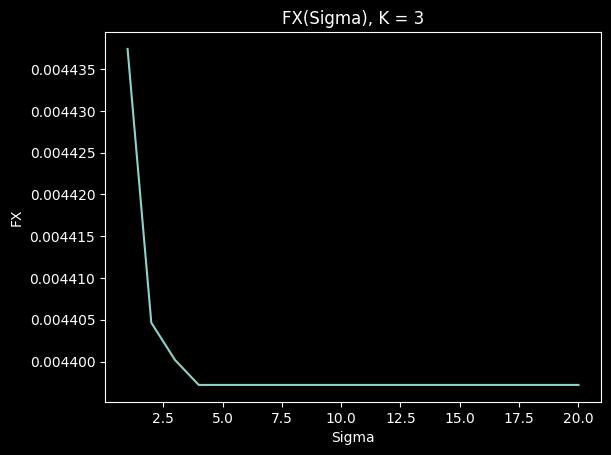

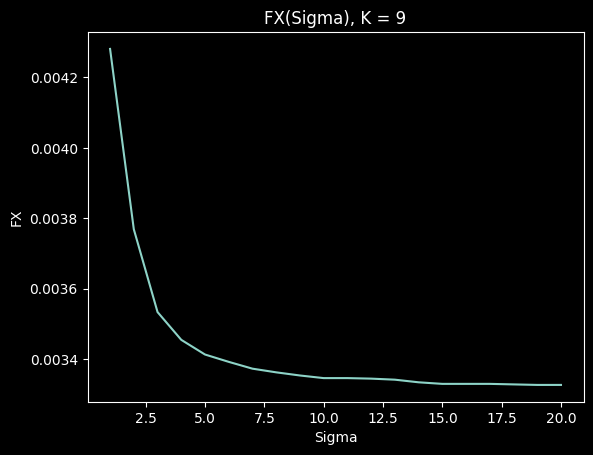

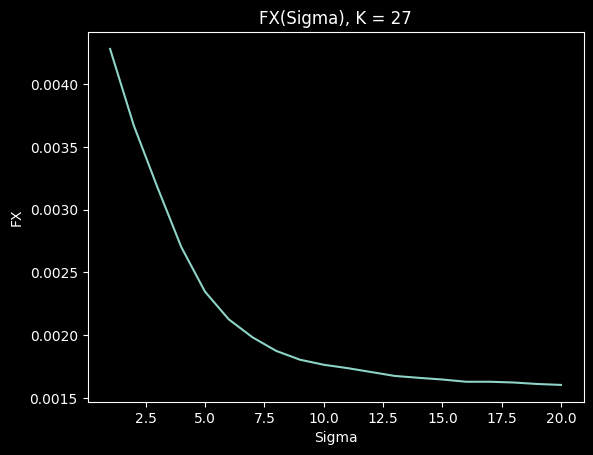

In [19]:
# Creamos dos listas para guardar sigmas y métricas de FX
sigma_range = range(1,21)

sigmas_k3, FXs_k3 = FX_values(img,sigma_range, 3)
sigmas_k9, FXs_k9 = FX_values(img, sigma_range, 9)
sigmas_k27, FXs_k27 = FX_values(img, sigma_range, 27)


# Por último, creamos y mostramos una gráfica de curva para ver como cambia la 
# métrica respecto a sigma:

plt.plot(sigmas_k3, FXs_k3)
plt.xlabel('Sigma')
plt.ylabel('FX')
plt.title('FX(Sigma), K = 3')
plt.show()

plt.plot(sigmas_k9, FXs_k9)
plt.xlabel('Sigma')
plt.ylabel('FX')
plt.title('FX(Sigma), K = 9')
plt.show()

plt.plot(sigmas_k27, FXs_k27)
plt.xlabel('Sigma')
plt.ylabel('FX')
plt.title('FX(Sigma), K = 27')
plt.show()

En los gráficos de arriba podemos observar el comportamiento esperado: A medida que sigma aumenta, la métrica de calidad FX disminuye. También podemos observar que a mayores tamaños de kernel, la disminución de calidad se hace más "lenta" a lo largo de sigma, ya que se logra un blurreado más suave.